# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке. 

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)	
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета	
- **Fare**: стоимость проезда пассажира	
- **Cabin**: номер каюты	
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/data_science/datasets/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подготовка и первичный анализ данных

In [ ]:
data = pd.read_csv(way + 'titanic_train.csv')

In [ ]:
data.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN


Установите количество пропущенных значений поля <code>age</code>:

In [ ]:
data.age.isna().sum()

199

Определите долю выживших

In [ ]:
data.survived.sum()/len(data.survived)

0.382262996941896

Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [ ]:
delete = ['ticket']
for col in data:
    if data[col].isna().sum()/len(data[col]) > 1/3:
        delete.append(col)

In [ ]:
delete

['ticket', 'cabin', 'home.dest']

In [ ]:
df = data.drop(columns=delete)
df.head(5)

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,7.2292,C
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,9.5000,S


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>. 

In [ ]:
df['fam_size'] = df.sibsp + df.parch
df = df.drop(columns=["sibsp", "parch"])
df.fam_size.mean()

0.8664627930682977

In [ ]:
df.head(5)

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0


Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [ ]:
# число предикторов
len(df.columns) - 1

7

На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [ ]:
female1 = df.loc[df['pclass'].isin([1]) & df.sex.isin(['female'])]
female1['survived'].sum() / female1.shape[0]

0.9711538461538461

Постройте гистограммы выжиших и невыживших по возрастам.

<Axes: xlabel='age', ylabel='Count'>

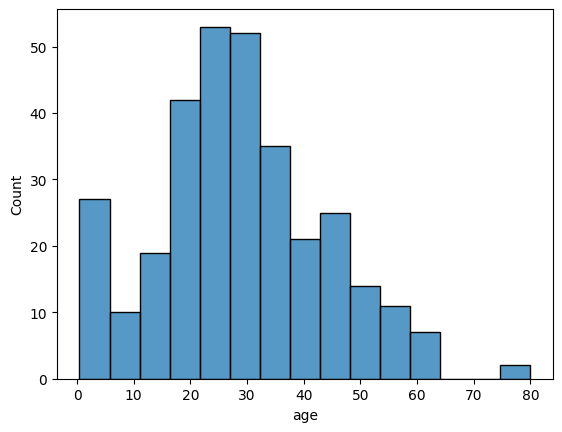

In [ ]:
tmp = df[df.survived.isin([1])]
sns.histplot(data=tmp, x=tmp.age)

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [ ]:
df1 = df.select_dtypes(include='number')
df1 = df1.dropna()

In [ ]:
from sklearn.model_selection import train_test_split
model = LogisticRegression(random_state=11, max_iter=1000)

In [ ]:
train_df, test_df = train_test_split(df1, test_size=0.2, random_state=11, stratify=df1['survived'])

In [ ]:
model.fit(train_df.drop('survived', axis = 1), train_df['survived'])

LogisticRegression(max_iter=1000, random_state=11)

In [ ]:
pred = model.predict(test_df.drop('survived', axis = 1))
f1_score(test_df.survived, pred)

0.5471698113207547

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [ ]:
df2 = df.select_dtypes(include='number')

In [ ]:
df2.fillna(df2.mean(), inplace=True)

In [ ]:
train_df, test_df = train_test_split(df2, test_size=0.2, random_state=11, stratify=df2['survived'])
model = LogisticRegression(random_state=11, max_iter=1000)
model.fit(train_df.drop('survived', axis = 1), train_df['survived'])
pred = model.predict(test_df.drop('survived', axis = 1))
f1_score(test_df['survived'], pred)

0.4297520661157025

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку. 

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [ ]:
df3 = df.copy()
df3.head(5)

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0


In [ ]:
df3['honorific'] = df3.name.str.extract(r'([A-Z][a-z]*\.)')

In [ ]:
len(df3.honorific.unique())
# число уникальных обращений

14

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [ ]:
mr = ["Rev.", 'Col.', 'Dr.', 'Major.', 'Don.', 'Capt.']
mrs = ['Dona.', 'Countess.']
miss = ['Mlle.', 'Ms.']

In [ ]:
df3['honorific'] = df3.honorific.replace(mr, 'Mr.')
df3['honorific'] = df3.honorific.replace(mrs, 'Mrs.')
df3['honorific'] = df3.honorific.replace(miss, 'Miss.')
df3['honorific'].unique()

array(['Miss.', 'Mrs.', 'Mr.', 'Master.'], dtype=object)

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [ ]:
df3.loc[df3.honorific.isin(['Master.']) & df3.sex.isin(['male'])].shape[0]/df3.loc[df3.sex.isin(['male'])].shape[0]

0.07232704402515723

Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [ ]:
df3.loc[df3.honorific.isin(['Miss.'])]['age'].mean()

22.00576540880503

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [ ]:
# средние значения возрастов согласно honorific:

avg = {}
for name in df3.honorific.unique():
    avg[name] = df3.loc[df3.honorific.isin([name])]['age'].mean()

In [ ]:
avg

{'Miss.': 22.00576540880503,
 'Mrs.': 36.98425196850393,
 'Mr.': 32.90043763676149,
 'Master.': 5.128205128205129}

In [ ]:
# заполнение пропусков средними по возрасту значениями

for name in avg:
    #df3.loc[df3.honorific.isin([name])].fillna(avg[name], inplace=True)
    df3.loc[df3.honorific.isin([name])] = df3.loc[df3.honorific.isin([name])].replace(np.NaN, avg[name])

In [ ]:
df3 = df3.select_dtypes(include='number')

In [ ]:
train_df, test_df = train_test_split(df3, test_size=0.2, random_state=11, stratify=df3['survived'])

model = LogisticRegression(random_state=11, max_iter=1000)
model.fit(train_df.drop('survived', axis = 1), train_df['survived'])

pred = model.predict(test_df.drop('survived', axis = 1))
f1_score(test_df['survived'], pred)

0.43902439024390244

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [ ]:
df4 = df.copy().drop(columns=['name'])

In [ ]:
df4.age = df3.age

In [ ]:
df4 = pd.get_dummies(df4, drop_first=True)

In [ ]:
train_df, test_df = train_test_split(df4, test_size=0.2, random_state=11, stratify=df4['survived'])

model = LogisticRegression(random_state=11, max_iter=1000)
model.fit(train_df.drop('survived', axis = 1), train_df['survived'])

pred = model.predict(test_df.drop('survived', axis = 1))
f1_score(test_df['survived'], pred)

0.6575342465753424

# Полный анализ

In [78]:
train_df2 = pd.read_csv(way + 'titanic_train.csv')
test_df2 = pd.read_csv(way + 'titanic_reserved.csv')

In [79]:
train_df2.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN


In [80]:
train_df2['embarked'].unique()

array(['Q', 'C', 'S'], dtype=object)

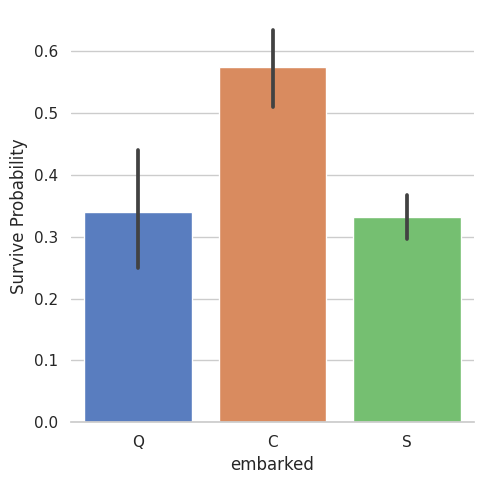

In [81]:
g = sns.catplot(x="embarked",y="survived",data=train_df2,kind="bar", palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Survive Probability")
plt.show()

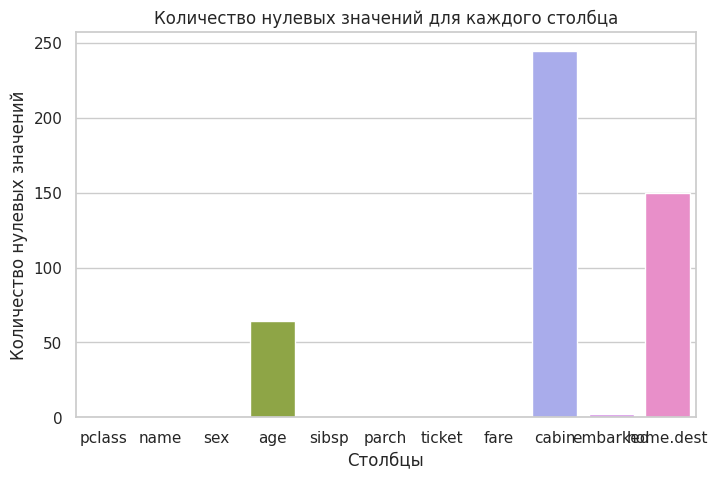

In [82]:
nan_counts = test_df2.isna().sum()

# Создание графика
sns.set(style='whitegrid')
plt.figure(figsize=(8, 5))
sns.barplot(x=nan_counts.index, y=nan_counts.values)
plt.title('Количество нулевых значений для каждого столбца')
plt.xlabel('Столбцы')
plt.ylabel('Количество нулевых значений')
plt.show()

In [83]:
mr = ["Rev.", 'Col.', 'Dr.', 'Major.', 'Don.', 'Capt.']
mrs = ['Dona.', 'Countess.']
miss = ['Mlle.', 'Ms.']

train_df2['honorific'] = train_df2['name'].str.extract(r'([A-Z][a-z]*\.)')

def optimize(df):
  df['honorific'] = df.name.str.extract(r'([A-Z][a-z]*\.)')
  df['honorific'] = df.honorific.replace(mr, 'Mr.')
  df['honorific'] = df.honorific.replace(mrs, 'Mrs.')
  df['honorific'] = df.honorific.replace(miss, 'Miss.')


  avg = {}
  for name in df.honorific.unique():
    avg[name] = train_df2.loc[train_df2.honorific.isin([name])]['age'].mean()
  for name in avg:
    df.loc[df.honorific.isin([name])] = df.loc[df.honorific.isin([name])].replace(np.NaN, avg[name])
  
  df["sex"] = df["sex"].map({"male": 0, "female":1})
  df["sex"] = df["sex"].astype(int)

  df['fam_size'] = df.sibsp + df.parch

  df.drop(['name', 'honorific', 'home.dest', "sibsp", "parch", 'ticket', 'cabin', 'embarked'], axis = 1, inplace = True)
  #df = pd.get_dummies(df, drop_first=True)

  return df

test_df2 = optimize(test_df2)
train_df2 = optimize(train_df2)

In [84]:
train_df2.head(3)

,pclass,survived,sex,age,fare,fam_size
0,3,1,1,22.005765,7.7333,0
1,3,1,1,22.005765,7.7500,0
2,3,1,1,38.000000,7.2292,0


In [85]:
model = LogisticRegression(random_state=11, max_iter=1000)
model.fit(train_df2.drop('survived', axis = 1), train_df2['survived'])

pred = model.predict(test_df2)
pred

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,